<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex3/3_notebook2_GPU/3_2_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Model 2 - Sarcasm detection
**train-balanced-sarcasm.csv**

In [ ]:
# GPU information
!nvidia-smi

Wed Dec  4 18:53:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   44C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip uninstall -q -y tensorflow

In [ ]:
!pip install -q keras-hub
!pip install -q tensorflow==2.18

In [ ]:
!pip show tensorflow

Name: tensorflow
Version: 2.17.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras_hub
import random
import tensorflow as tf
from wordcloud import WordCloud
import keras
import torch
import os
import re
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Restrict TensorFlow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]  # 4GB
            )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
# pandas display options for easier debugging
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [ ]:
folder_path = '/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex3/3_notebook2_GPU'
os.chdir(folder_path)

In [ ]:
sarcasm_data = pd.read_csv("data/train-balanced-sarcasm.csv")
print(sarcasm_data.shape)
sarcasm_data.head()

(1010826, 10)


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."
1,0,You do know west teams play against west teams more than east teams right?,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.
2,0,"They were underdogs earlier today, but since Gronk's announcement this afternoon, the Vegas line has moved to patriots -1",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york nigga"" ones are.",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for that. It was made by our boy EASports_MUT


## Data preprocessing

In [ ]:
sarcasm_data.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc', 'parent_comment'], axis=1, inplace=True)

In [ ]:
sarcasm_data.dropna(inplace=True)
sarcasm_data.head()
sarcasm_data['label'].value_counts()

,count
label,
0,505403
1,505368


In [ ]:
sarcasm_data_test = sarcasm_data.iloc[950000:]
sarcasm_data = sarcasm_data.iloc[0:950000]

In [ ]:
# check the value counts, balance seems ok
print(sarcasm_data['label'].value_counts())
print()
print(sarcasm_data_test['label'].value_counts())

label
0    478446
1    471554
Name: count, dtype: int64

label
1    33814
0    26957
Name: count, dtype: int64


In [ ]:
# dict for correcting common spelling mistakes and contractions
mispell_dict = {"ain't": "is not", "cannot": "can not", "aren't": "are not", "can't": "can not", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is", "how'd": "how did",
                "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have", "I'm": "I am",
                "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not",
                "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not",
                "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have",
                "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "wont": "will not", "won't've": "will not have", "would've": "would have",
                "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color',
                'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor',
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                'theBest': 'the best', 'howdoes': 'how does', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'}

mispell_dict = {k.lower(): v.lower() for k, v in mispell_dict.items()}

In [ ]:
# preprocess text by normalizing, correcting misspellings, and removing unnecessary characters
def preprocessing_text(s):
    s = str(s).lower().strip()
    s = " ".join([mispell_dict[word] if word in mispell_dict.keys() else word for word in s.split()])
    s = re.sub('\n', '', s)
    s = re.sub(r"([?!,+=—&%\'\";:¿।।।|\(\){}\[\]//])", r" \1 ", s)
    s = re.sub('[ ]{2,}', ' ', s).strip()
    return s

In [ ]:
# apply preprocessing_text function
sarcasm_data['comment'] = sarcasm_data['comment'].apply(preprocessing_text)
sarcasm_data.head()

,label,comment
0,0,nc and nh.
1,0,you do know west teams play against west teams more than east teams right ?
2,0,"they were underdogs earlier today , but since gronk ' s announcement this afternoon , the vegas line has moved to patriots -1"
3,0,"this meme is not funny none of the "" new york nigga "" ones are."
4,0,i could use one of those tools.


In [ ]:
# apply the same process to test data too
sarcasm_data_test['comment'] = sarcasm_data_test['comment'].apply(preprocessing_text)
sarcasm_data_test.head()

,label,comment
950044,1,there is no palestine
950045,0,this would never fucking work for me.
950046,1,"let us just assume all men are pedophiles , that is makes everything better."
950047,1,just another example of god ' s perfect design.
950048,1,ever heard of ron paul ?


## Embedding and tokenizing

In [ ]:
TOTAL_WORDS = 40000 # total unique words
MAX_LEN = 50 # max words in a sentence
EMBEDDING_SIZE = 300 # width of of 1D embedding vector

In [ ]:
%%time
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=TOTAL_WORDS)
tokenizer.fit_on_texts(list(sarcasm_data['comment']))

# Generate sequences using texts_to_sequences
train_sequences = tokenizer.texts_to_sequences(sarcasm_data['comment'])
train_data = tf.keras.utils.pad_sequences(train_sequences, maxlen = MAX_LEN)
target = sarcasm_data['label']

# also apply test data
test_sequences = tokenizer.texts_to_sequences(sarcasm_data_test['comment'])
test_data = tf.keras.utils.pad_sequences(test_sequences, maxlen = MAX_LEN)

CPU times: user 28.6 s, sys: 205 ms, total: 28.8 s
Wall time: 28.8 s


In [ ]:
%%time
EMBEDDING_FILE = "crawl-300d-2M.vec"

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open(EMBEDDING_FILE)))

word_index = tokenizer.word_index
nb_words = min(TOTAL_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_SIZE))

0it [00:00, ?it/s]

CPU times: user 2min 2s, sys: 5.23 s, total: 2min 7s
Wall time: 2min 9s


In [ ]:
# filter out a smaller portion of the word embeddings
for word, i in tqdm(word_index.items()):
    if i >= TOTAL_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

  0%|          | 0/161878 [00:00<?, ?it/s]

In [ ]:
embedding_matrix.shape

(40000, 300)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    tf.random.set_seed(seed)

# We fix all the random seed so that, we can reproduce the results.
seed_everything(2020)

## Model build and train

In [ ]:
optimizer = tf.keras.optimizers.Adam

In [ ]:
input_layer = tf.keras.layers.Input(shape=(MAX_LEN,))
embedding_layer = tf.keras.layers.Embedding(TOTAL_WORDS, EMBEDDING_SIZE, weights = [embedding_matrix])(input_layer)
LSTM_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences = True))(embedding_layer)
maxpool_layer = tf.keras.layers.GlobalMaxPool1D()(LSTM_layer)
dense_layer_1 = tf.keras.layers.Dense(64, activation="relu")(maxpool_layer)
dropout_1 = tf.keras.layers.Dropout(0.5)(dense_layer_1)
dense_layer_2 = tf.keras.layers.Dense(32, activation="relu")(dropout_1)
dropout_2 = tf.keras.layers.Dropout(0.5)(dense_layer_2)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(dropout_2)
model = tf.keras.models.Model(input_layer, output_layer)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 50, 300)             │      12,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         439,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,457,857 (47.52 MB)

 Trainable params: 12,457,857 (47.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Keras callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2,monitor='val_loss',min_delta=0, mode='min', restore_best_weights=False, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.000001, patience=1, mode='min',factor=0.1,min_delta=0.01,verbose=1)

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10

history = model.fit(
    train_data, target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - accuracy: 0.7366 - loss: 0.5331 - val_accuracy: 0.7354 - val_loss: 0.5246 - learning_rate: 0.0010
Epoch 2/10
5936/5938 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7625 - loss: 0.4958
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 97s 16ms/step - accuracy: 0.7625 - loss: 0.4958 - val_accuracy: 0.7354 - val_loss: 0.5292 - learning_rate: 0.0010
Epoch 3/10
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7860 - loss: 0.4576
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
5938/5938 ━━━━━━━━━━━━━━━━━━━━ 98s 16ms/step - accuracy: 0.7860 - loss: 0.4576 - val_accuracy: 0.7299 - val_loss: 0.5742 - learning_rate: 1.0000e-04
Epoch 3: early stopping


In [ ]:
model.save('models/sarcasm_model.h5')

## Model evaluation

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

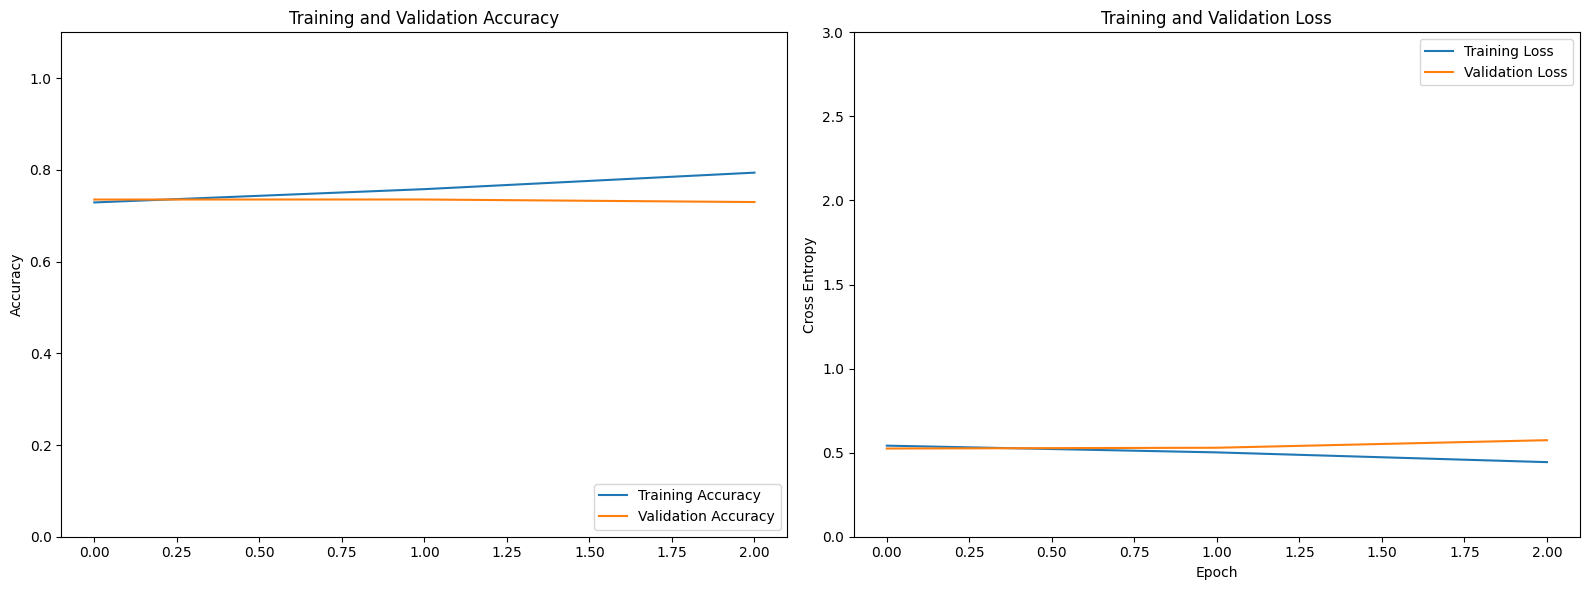

In [ ]:
plt.figure(figsize=(16, 6))

# Training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])
plt.title('Training and Validation Accuracy')

# Training and validation öoss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [ ]:
# Binary crossentropy used
# Process data with 0.5 threshold
# 0.5 or more => sarcastic, less than 0.5 => not sarcastic
y_proba = model.predict(test_data)
y_pred = np.argmax(y_proba, axis=1)
y_pred_labels = []

# sarcasm based on threshold
for prob in y_proba:
  if prob >= 0.5:
    y_pred_labels.append(1)
  else:
    y_pred_labels.append(0)

y_true_labels = sarcasm_data_test['label']

1900/1900 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [ ]:
sarcasm_data[sarcasm_data['label']==1].sample(10)

,label,comment
73971,1,"i mean it only made it to the front page yesterday , so i am sure not that many people saw it !"
554757,1,"hey , last time we got some pretty useful railroads out of the deal , who knows what they will build this time ?"
927185,1,shut up liberal.
331306,1,"haha yeah , "" big game , james... """
615568,1,because obviously you are trying to do something illegal.
135617,1,but why would you ruin the surprise
867894,1,yeah this is totally made up and does not happen ever !
745101,1,more benzos ?
752585,1,but why would they want ' some money ' when they could force you to give them ' more money ' ?
396022,1,sher does not it cure cancer ?


**"sun rises from the east"**

In [ ]:
sentence_latin = "sun rises from the east"
sentence = preprocessing_text(sentence_latin)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = tf.keras.utils.pad_sequences(sentence, maxlen = MAX_LEN)
sentence

sun rises from the east


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1679, 9612,   55,    1, 1062]], dtype=int32)

In [ ]:
# Make the prediction.
prediction = model.predict(sentence)
prediction[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


0.10555995

In [ ]:
print(f"The sentence: {sentence_latin} --- has probability of %.3f percent"%(prediction[0][0]*100))

The sentence: sun rises from the east --- has probability of 10.556 percent


**"Isn't it great that, your girlfriend dumped you?"**

In [ ]:
sentence_latin = "Isn't it great that, your girlfriend dumped you?"
sentence = preprocessing_text(sentence_latin)
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
sentence = tf.keras.utils.pad_sequences(sentence, maxlen = MAX_LEN)
sentence

is not it great that , your girlfriend dumped you ?


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    2,    7,    8,
         121,   10,   39, 1657, 9811,    6]], dtype=int32)

In [ ]:
# Make the prediction.
prediction = model.predict(sentence)
prediction[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


0.5938701

In [ ]:
print(f"The sentence: {sentence_latin} --- has probability of %.3f percent"%(prediction[0][0]*100))

The sentence: Isn't it great that, your girlfriend dumped you? --- has probability of 59.387 percent


### ROC curve
**Receiver Operating Characteristic curve**
shows how well a classification model separates two classes

*   **True Positive Rate:** How many actual positives the model correctly identified.
*   **False Positive Rate:** How many negatives were wrongly predicted as positives.


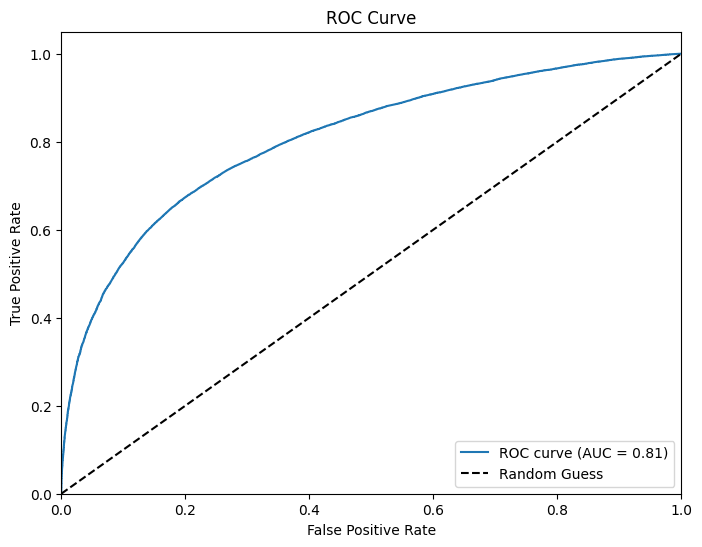

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_labels, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Precision-Recall curve
**(PR) curve**
shows the balance between precision and recall for a classification model at different thresholds.

*   **Precision:** How many actual positives the model correctly identified.
*   **Recall:** Out of all the actual positives, how many were correctly identified.


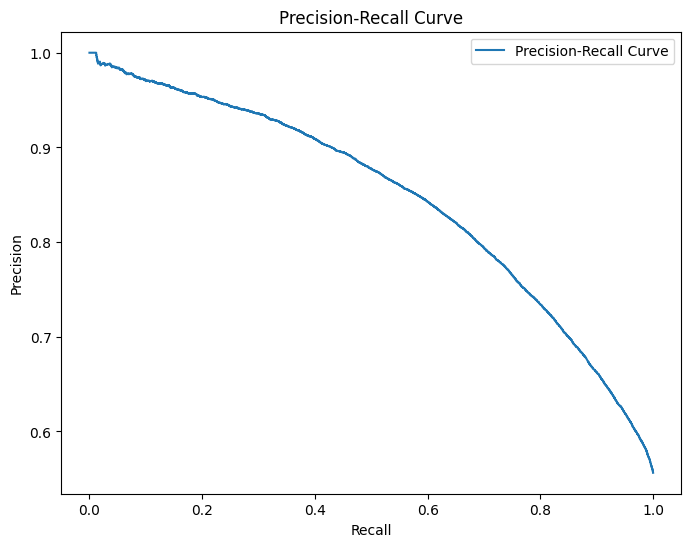

In [ ]:
# precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true_labels, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

### Distribution of Predicted Probabilities

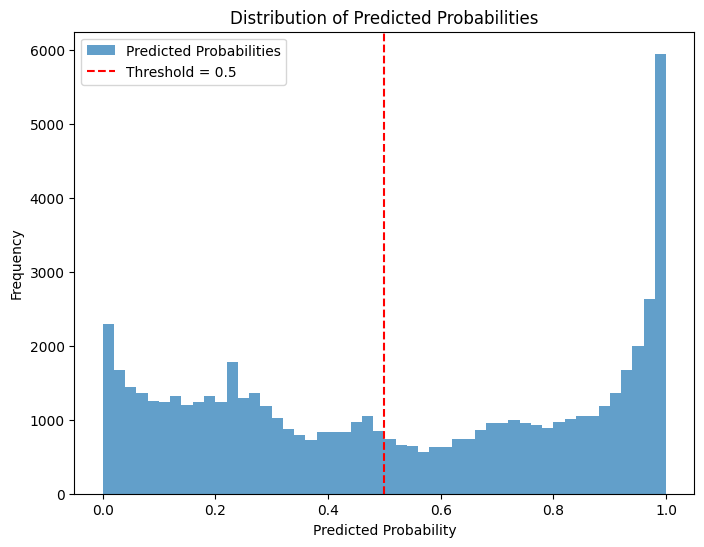

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(y_proba, bins=50, alpha=0.7, label='Predicted Probabilities')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend(loc='best')
plt.show()

### Misclassifications examples

In [ ]:
sarcasm_data_test['predicted_label'] = y_pred_labels
sarcasm_data_test['predicted_proba'] = y_proba
misclassified = sarcasm_data_test[sarcasm_data_test['label'] != sarcasm_data_test['predicted_label']]

# 5 misclassifications
misclassified = misclassified.assign(error_margin=lambda x: abs(x['predicted_proba'] - x['label']))
misclassified.sort_values('error_margin', ascending=False).head(5)

,label,comment,predicted_label,predicted_proba,error_margin
984690,1,i am from ubc and your attempts are futile.,0,0.000044,0.999956
971464,1,choo choo,0,0.000085,0.999915
1008934,1,zing !,0,0.000132,0.999868
1003962,1,"in my opinion , if a manager uses it in conjunction with any business practice , it is probably being used correctly , since i do not think most business practices were designed to be effective !",0,0.000231,0.999769
998509,1,psn +,0,0.000271,0.999729


### Confusion matrix

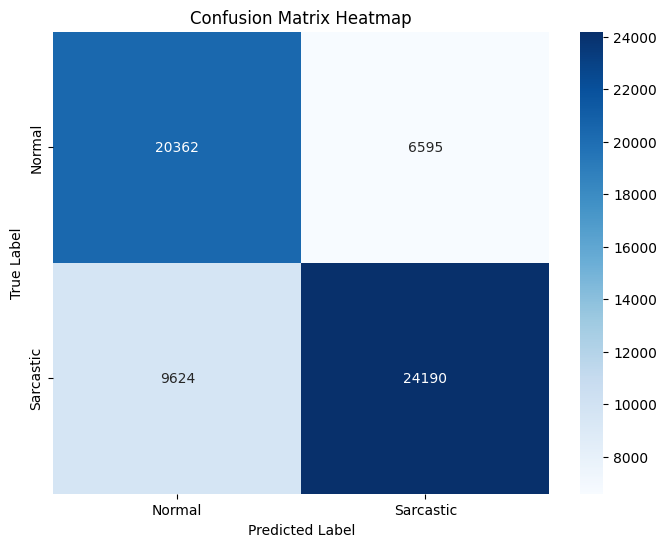

In [ ]:
# confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Sarcastic"], yticklabels=["Normal", "Sarcastic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

### World cloud sarcastic / non-sarcastic comments

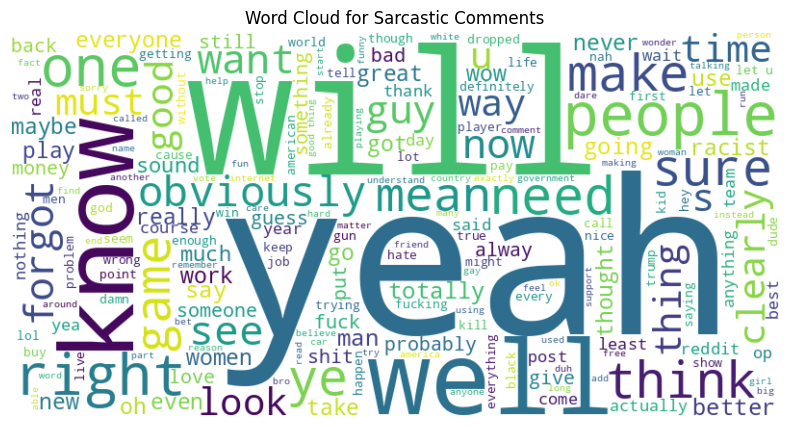

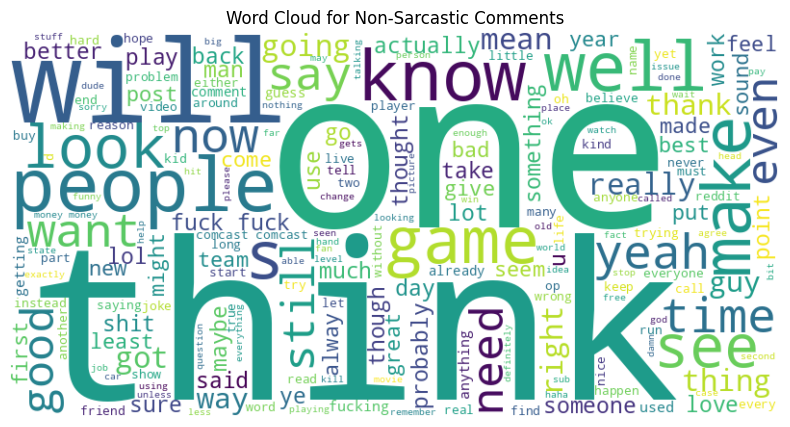

In [ ]:
sarcastic_comments = " ".join(sarcasm_data[sarcasm_data['label'] == 1]['comment'])
non_sarcastic_comments = " ".join(sarcasm_data[sarcasm_data['label'] == 0]['comment'])

# sarcastic comments
sarcastic_wc = WordCloud(width=800, height=400, background_color='white').generate(sarcastic_comments)
plt.figure(figsize=(10, 5))
plt.imshow(sarcastic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Sarcastic Comments')
plt.show()

# non-sarcastic comments
non_sarcastic_wc = WordCloud(width=800, height=400, background_color='white').generate(non_sarcastic_comments)
plt.figure(figsize=(10, 5))
plt.imshow(non_sarcastic_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Sarcastic Comments')
plt.show()